In [1]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

In [2]:
# BLIP NLVR
import sys
sys.path.append("BLIP")
from pipelines_train import *
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = BLIPClassifier(BLIPNLVRHead(med_config="BLIP/configs/med_config.json", device=device, dropout=True), med_config="BLIP/configs/med_config.json", pretrain_path="BLIP/blip_base.pth", device=device, text_inject=True)

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

def save_path(i):
    return f"model_checkpoints/blip_nlvr/blip_nlvr_mlp_e{i}"
save_path(5)


load checkpoint from BLIP/blip_base.pth


'model_checkpoints/blip_nlvr/blip_nlvr_mlp_e5'

In [2]:
# BLIP w/ CLS Head
import sys
sys.path.append("BLIP")
from pipelines_train import *
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = BLIPClassifier(BLIPDeepHead1(med_config="BLIP/configs/med_config.json", device=device), med_config="BLIP/configs/med_config.json", pretrain_path="BLIP/blip_base.pth", device=device, text_inject=True)

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

def save_path(i):
    return f"model_checkpoints/blip_deep_mlp_1/blip_deep_mlp_1_e{i}"
save_path(5)

load checkpoint from BLIP/blip_base.pth


'model_checkpoints/blip_deep_mlp_1/blip_deep_mlp_1_e5'

In [2]:
# BLIP w/ CLS Head
import sys
sys.path.append("BLIP")
from pipelines_train import *
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = BLIPClassifier(BLIPDeepHead2(med_config="BLIP/configs/med_config.json", device=device), med_config="BLIP/configs/med_config.json", pretrain_path="BLIP/blip_base.pth", device=device, text_inject=True)

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

def save_path(i):
    return f"model_checkpoints/blip_deep_mlp_2/blip_deep_mlp_2_e{i}"
save_path(5)

load checkpoint from BLIP/blip_base.pth


'model_checkpoints/blip_deep_mlp_2/blip_deep_mlp_2_e5'

In [2]:
# BLIP w/ CLS Head
import sys
sys.path.append("BLIP")
from pipelines_train import *
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = BLIPClassifier(BLIPDeepHead3(med_config="BLIP/configs/med_config.json", device=device, dropout=True), med_config="BLIP/configs/med_config.json", pretrain_path="BLIP/blip_base.pth", device=device, text_inject=True)

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

def save_path(i):
    return f"model_checkpoints/blip_deep_mlp_3/blip_deep_mlp_3_e{i}"
save_path(5)

load checkpoint from BLIP/blip_base.pth


'model_checkpoints/blip_deep_mlp_3/blip_deep_mlp_3_e5'

In [2]:
# BLIP w/ CLS Head
import sys
sys.path.append("BLIP")
from pipelines_train import *
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = BLIPClassifier(BLIPDeepHead4(med_config="BLIP/configs/med_config.json", device=device, dropout=True), med_config="BLIP/configs/med_config.json", pretrain_path="BLIP/blip_base.pth", device=device, text_inject=True)

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

def save_path(i):
    return f"model_checkpoints/blip_deep_mlp_4/blip_deep_mlp_4_e{i}"
save_path(5)

load checkpoint from BLIP/blip_base.pth


'model_checkpoints/blip_deep_mlp_4/blip_deep_mlp_4_e5'

In [2]:
# BLIP w/ CLS Head
import sys
sys.path.append("BLIP")
from pipelines_train import *
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = BLIPClassifier(BLIPDeepHead5(med_config="BLIP/configs/med_config.json", device=device, dropout=True), med_config="BLIP/configs/med_config.json", pretrain_path="BLIP/blip_base.pth", device=device, text_inject=True)

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

def save_path(i):
    return f"model_checkpoints/blip_deep_mlp_5/blip_deep_mlp_5_e{i}"
save_path(5)

load checkpoint from BLIP/blip_base.pth


'model_checkpoints/blip_deep_mlp_4/blip_deep_mlp_4_e5'

In [ ]:
# BLIP w/ SVM Head
import sys
sys.path.append("BLIP")
from pipelines_train import *
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = BLIPClassifier(BLIPSVMHead(), med_config="BLIP/configs/med_config.json", pretrain_path="BLIP/blip_base.pth", device=device)

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

def save_path(i):
    return f"model_checkpoints/blip_svm/blip_svm"
save_path(5)

In [3]:
from RedditData import *

main_csv_path = "../datasets/main_val.csv"

train_dataset = RedditDataset("../datasets", main_csv=main_csv_path, im_transform=train_transform)
train_sampler = RedditDataSampler("../datasets", main_csv=main_csv_path, upsampling=False)

val_dataset = RedditDataset("../datasets", main_csv=main_csv_path, split="valid", im_transform=val_transform)
val_sampler = RedditDataSampler("../datasets", main_csv=main_csv_path, split="valid")

train_dataloader = DataLoader(train_dataset, batch_sampler=BatchSampler(train_sampler, batch_size, True))
val_dataloader = DataLoader(val_dataset, batch_sampler=BatchSampler(val_sampler, 1, True))

In [4]:
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
def validation(classifier, val_dataloader):
    loss = CrossEntropyLoss()
    with torch.no_grad():
        loss_val = 0
        n = len(val_dataloader)
        for i in val_dataloader:
            text,image,label,has_image = i
            image = image.float()
            label = F.one_hot(label, num_classes=2).float()
            loss_val += loss(torch.from_numpy(classifier(image, text, has_image)).float(), label).item()/n

        return loss_val
    
#validation(classifier, val_dataloader)

In [5]:


for i in range(10):
    pbar = tqdm(train_dataloader, "Loss - ")
    for idx,data in enumerate(pbar):
        text,image,label,has_image = data
        image = image.float()
        label = F.one_hot(label, num_classes=2).float()
        classifier.train(image,text,label,has_image)
        if idx==len(pbar)-1:
            pbar.set_description("Validation loss - %f" % (validation(classifier, val_dataloader)))
    classifier.save(save_path(i))


Validation loss - 0.448967: 100%|██████████| 103/103 [03:01<00:00,  1.76s/it]


### Calculate metrics

In [ ]:
for i in range(10):
    classifier.load(save_path(i))
    print(validation(classifier, val_dataloader))

0.565385476258642


KeyboardInterrupt: 

In [6]:
def get_val_output(classifier, dataloader):
    ret = []
    for batch in dataloader:
        text,image,label,has_image = batch
        image = image.float()
        yp = classifier(image,text,has_image)
        for i in range(len(text)):
            ret.append(((text[i],image[i].cpu().detach().numpy(),label[i].cpu().detach().numpy(),has_image[i].cpu().detach().numpy()),yp[i]))
    return ret

In [7]:
from sklearn.metrics import roc_curve,roc_auc_score
def get_failure_cases(model_out, thresh=0.5):
    idx = []
    for i in range(len(model_out)):
        (text,image,label,has_image),pred = model_out[i]
        gt = label
        ans = 1 if pred[1] >= thresh else 0
        if ans != gt: idx.append(i)
    return idx

def get_metrics(model_out):
    scores = [i[1][1] for i in model_out]
    roc=roc_curve([i[0][2] for i in model_out], scores)
    auc = roc_auc_score([i[0][2] for i in model_out], scores)
    num1 = sum([i[0][2] for i in model_out])
    num0 = len(model_out) - num1
    fp = sum([1 if i[0][2]==0 and np.round(i[1][1])==1 else 0 for i in model_out])
    fn = sum([1 if i[0][2]==1 and np.round(i[1][1])==0 else 0 for i in model_out])
    tp = sum([1 if i[0][2]==1 and np.round(i[1][1])==1 else 0 for i in model_out])
    tn = sum([1 if i[0][2]==0 and np.round(i[1][1])==0 else 0 for i in model_out])
    correct = sum([1 if i[0][2]==np.round(i[1][1]) else 0 for i in model_out])
    return roc,auc,fp,fn,tp,tn,num0,num1,correct

In [44]:
classifier.load(save_path(9))

In [45]:
save_path(0)

'model_checkpoints/blip_deep_mlp_4/blip_deep_mlp_4_e0'

In [46]:
model_out = get_val_output(classifier, val_dataloader)
roc,auc,fp,fn,tp,tn,num0,num1,correct = get_metrics(model_out)

In [47]:
fpr,tpr,thresh = roc

In [48]:
auc,fp,fn,tp,tn,num0,num1,correct

(0.9228524743230625, 23, 43, 167, 181, 204, 210, 348)

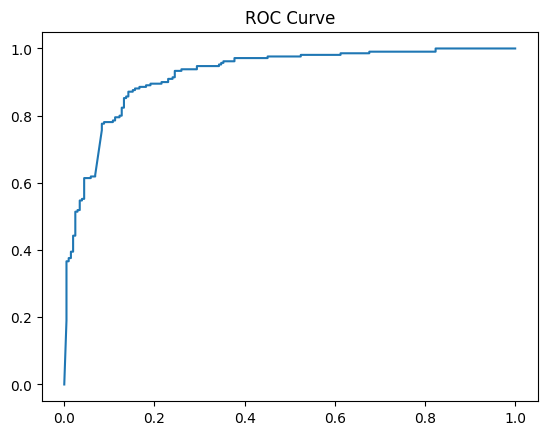

In [49]:
from matplotlib import pyplot as plt
plt.title("ROC Curve")
plt.plot(fpr,tpr)

### Visualize failure cases

In [ ]:
fails = get_failure_cases(model_out)

In [ ]:
len(fails)

In [ ]:
sum([model_out[fail][0][2] for fail in fails])

In [ ]:
i=14
(text,image,label,has_image),yp = model_out[i]
text,label,has_image

In [ ]:
import matplotlib.pyplot as plt

im = np.transpose(image, (1,2,0))

plt.imshow(im)